---
title: STATS 3DA3
subtitle: Homework Assignment 6
author: "Ruziyi Duan (400292089), Xiangyi Li (400297427), Jinglong Yu (400334351)"
date: 16/04/2024
format: pdf
header-includes:
   - \usepackage{amsmath}
   - \usepackage{bbm}
   - \usepackage{array}
   - \usepackage{multirow}
   - \usepackage{graphicx}
   - \usepackage{float}
   - \usepackage{apacite}
   - \usepackage{natbib}
execute: 
  echo: true
fontsize: 11pt
bibliography: ref_proj.bib
geometry: margin = 1in
linestretch: 1.5
---

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import neighbors

1. **Classification Problem Identification:**
This dataset collects indicators from patients in the hospital over a two-month period, which can be used to analyze the physical condition of different patients according to the model and to analyze and predict what physical indicators are most useful for obtaining ckd, using the presence or absence of ckd as the goal.

Data overview

In [21]:
ckd = pd.read_csv("kidney_disease.csv") # save csv in dataset ckd
print(ckd.head(5))
print(ckd.dtypes)
print(ckd.shape[0])

   id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 rows x 26 columns]
id                  int64
age               float64
bp                

The kidney has both numerical and object variables. There are 26 variables and 400 observations. Some of the variables such as rbc, bc etc are binary object. It is easy to oberve that the dataset exist missing value. So for the further analysis we will transform the variables and handling missing value.

Missing Value Analysis and Handling

In [22]:
ckd.isna().sum() # check uniqueness
ckd = ckd.dropna(axis = 0) # drop dataset

Variable Transformation: categorical transform and standarlize

In [23]:
float_col=ckd.select_dtypes(include=["float64"]).columns
scalar=StandardScaler()
ckd[float_col]=scalar.fit_transform(ckd[float_col])

cat = ['pc', 'pcc',"rbc","ba","htn","dm","cad","appet","pe","ane"]
for col in cat:
    ckd[col] = pd.Categorical(ckd[col]).codes # categorical



Data overview(after transformed)

In [24]:
ckd.describe()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,sc,sod,pot,hemo,htn,dm,cad,appet,pe,ane
count,158.000000,1.580000e+02,1.580000e+02,1.580000e+02,1.580000e+02,1.580000e+02,158.000000,158.000000,158.000000,158.000000,...,158.000000,1.580000e+02,1.580000e+02,1.580000e+02,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,274.841772,8.432074e-17,5.846238e-16,-1.304161e-15,-1.349132e-16,-2.248553e-17,0.886076,0.816456,0.088608,0.075949,...,0.000000,9.893633e-16,5.621382e-17,2.698264e-16,0.215190,0.177215,0.069620,0.120253,0.126582,0.101266
std,102.998517,1.003180e+00,1.003180e+00,1.003180e+00,1.003180e+00,1.003180e+00,0.318729,0.388343,0.285080,0.265759,...,1.003180,1.003180e+00,1.003180e+00,1.003180e+00,0.412261,0.383065,0.255315,0.326292,0.333562,0.302640
min,3.000000,-2.817246e+00,-2.158952e+00,-2.713365e+00,-5.661221e-01,-3.122333e-01,0.000000,0.000000,0.000000,0.000000,...,-0.583015,-3.730148e+00,-6.165957e-01,-3.685029e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,243.000000,-6.669624e-01,-1.261282e+00,2.309247e-02,-5.661221e-01,-3.122333e-01,1.000000,1.000000,0.000000,0.000000,...,-0.485227,-5.154386e-01,-2.703085e-01,-3.784601e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,298.500000,6.057713e-02,5.340564e-01,2.309247e-02,-5.661221e-01,-3.122333e-01,1.000000,1.000000,0.000000,0.000000,...,-0.354843,2.034626e-02,-3.945044e-02,1.958388e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,355.750000,6.749439e-01,5.340564e-01,9.352451e-01,1.437770e-01,-3.122333e-01,1.000000,1.000000,0.000000,0.000000,...,-0.191863,6.900774e-01,7.597862e-02,7.266301e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,399.000000,2.162358e+00,3.227064e+00,9.352451e-01,2.273474e+00,5.854375e+00,1.000000,1.000000,1.000000,1.000000,...,4.241194,1.493755e+00,1.222489e+01,1.431451e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We observe that the std for the categorical variables are very low since it is neither 1 or 0 so the variability are very low. The other numeric variabels such as "sc" has relative high std which means they have higher variability. And we can see after drop the missing value. We have 158 availbe obervations

show the Association Between Variables
id has no relate to any other variables

<Axes: >

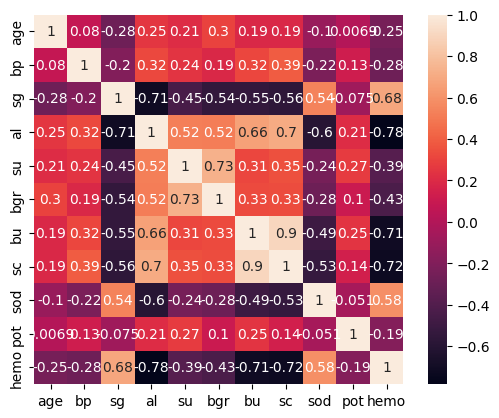

In [25]:
corr=ckd[float_col].corr()
sns.heatmap(corr,annot=True,cbar=True,square=True)

`bgr` and `su` have a quite high positive correlation which means sugar and the level of blood glucose random have a strong relationship. When sugar increases, the level of blood glucose random also tends to increase.

`al`, `bu`, and `sc` are highly negative correlated with `hemo` which means when albumin, blood urea, and serum creatinine have strong relationship with the level of hemoglobin. When they increase, the level of hemoglobin tends to decrease.

Outlier anaylsis

In [26]:
z_scores = ckd.select_dtypes(include='number').apply(zscore)
outliers = (z_scores > 3) | (z_scores < -3)
print(outliers.sum())

id        0
age       0
bp        1
sg        0
al        0
su        6
rbc       0
pc        0
pcc      14
ba       12
bgr       3
bu        4
sc        8
sod       4
pot       1
hemo      1
htn       0
dm        0
cad      11
appet     0
pe        0
ane       0
dtype: int64


 Decision trees are robust to outliers in general, as decision trees can adapt to them by choosing appropriate split points.

sub group anaylsis

Fit a classification tree to predict `classification` using all variables except `id` since it has no correlation with the classification of CKD.

In [27]:
X = ckd.drop(['id', 'classification'], axis=1)
y = ckd.classification

Data Splitting 30%/70%

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y)

In [29]:
ckd_cld = DecisionTreeClassifier(
    max_depth = 10, 
    random_state=0
) 

In [30]:
ckd_cld.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

<function matplotlib.pyplot.show(close=None, block=None)>

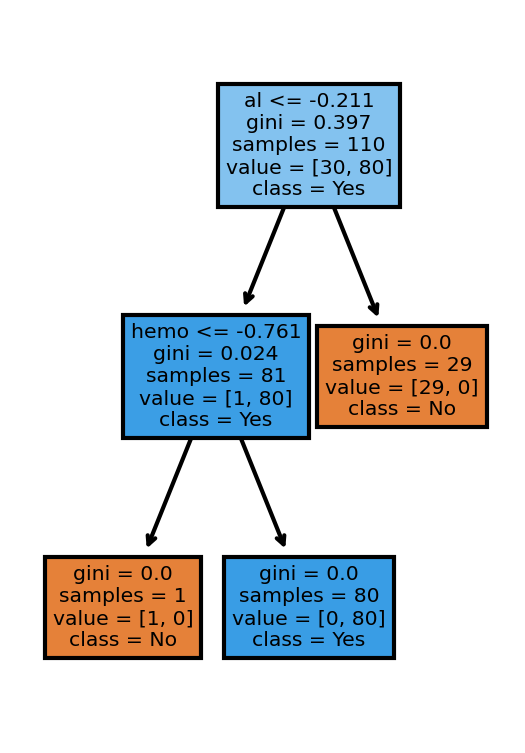

In [31]:
fig, axes = plt.subplots(
    nrows = 1,ncols = 1,figsize = (2,3), dpi=300
    )
plot_tree(
    ckd_cld, 
    max_depth= 2, 
    feature_names = X_train.columns.tolist(), 
    class_names=['No', 'Yes'], 
    filled = True
    )
plt.show

In [34]:
#KNN
# Let K = 5
knn5 = neighbors.KNeighborsClassifier(
n_neighbors = 5,
)
knn5.fit(X_train, y_train)

KNeighborsClassifier()

In [35]:
pred5 = knn5.predict(X_test)
print(round(metrics.accuracy_score(y_test, pred5),2))

AttributeError: 'Flags' object has no attribute 'c_contiguous'